# Naive Bayes Classifier

## If it meows like a cat: A primer on Conditional Probabilities

Let's consider the probability:

$$
    p(cat) = 0.5
$$

What does this probability mean? From a frequentist point of view, probabilities just represent the expected relative number of observations. Therefore, $p(cat) = 0.5$ only means, that a cat was observed $50\%$ of the time. However, in Bayesian statistics, probabilities can be used to express beliefs about the world. Here, $P(cat)$ could mean, that an observer is $50\%$ sure, that the animal in front of him his a cat. This notion of representing beliefs instead of frequencies is useful, since it allows us to state our beliefs depending on the information that we have. Enter *Conditional Probabilities*, where the likelihood of observing event $B$ after event $A$ is denoted as:

$$
    p(B | A) = \frac{ p(A, B) }{ p(A) }
$$

For example, the probability of roling a $6$ with a fair six-sided die is $P(X = 6) = 1/6$. However, if another player already told us that the result is even, the probability changes to

$$
    P(X = 6 | \text{$X$ is even}) = \frac{P(X = 6 \land \text{$X$ is even}) }{ P(\text{$X$ is even}) } = \frac{1}{6} : \frac{1}{2} = \frac{1}{3}
$$

Similarly, if the animal in front of us starts meowing, we might have a better idea, what kind of animal it actually is:

$$
    P(X = cat | \text{$X$ is meowing}) = 0.90
$$

But how can we actually update our beliefs, once new information becomes available? This is described by *Bayes Law*, which can be derived from the definition of conditional probabilities:

$$
    \underbrace{p(y \vert x)}_\text{posterior} = \frac{
            \overbrace{p(x \vert y)}^\text{likelihood} \overbrace{p(y)}^\text{prior}
        }{
            \underbrace{p(x)}_\text{evidence}
        }
$$

In the context of a machine learning classifier, $y$ could denote the class (e.g. "cat"), and $x$ could denote an observerd feature of that class (e.g. "meows"). Our prior assumption is given by the prior $p(y)$. It states our default belief of observing a certain class, without any other information about the observation $x$ available. For example, if you have observed that there are 3 times as many dogs as cats on the world, your prior about observing a cat could be $p(cat) = 0.25)$ and $p(dog) = 0.75$. We want to update our prior belief with the information from observation $x$ to obtain our *posterior* belief $p(y | x)$, i.e. our belief *after* observing $x$. Therefore, we multiply by the likelihood $p(x | y)$, which describes, how likely that observation is, under the assumption, that we have a certain class $y$ given. E.g., how likely is the animal to meow ($x$), if it is a cat ($y$)? Seems pretty likely, doesn't it? Finally, since probabilities should sum up to $1$, if have to divide by the evidene $p(x)$, i.e. the overall probability of observing $x$. Sometimes, you will see the normalization term being omitted for classification, since

$$
    p(y | x) \propto p(x | y) p(y)
$$



## A Naive Bayes Classifier

Enough with the theory already! Let's look at a practical example. Consider the following dataset about cats and dogs:

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(19)

In [6]:
from sklearn.datasets import load_iris

iris_ds = load_iris()
X = iris_ds["data"]
y = iris_ds["target"]
feature_names = iris_ds["feature_names"]

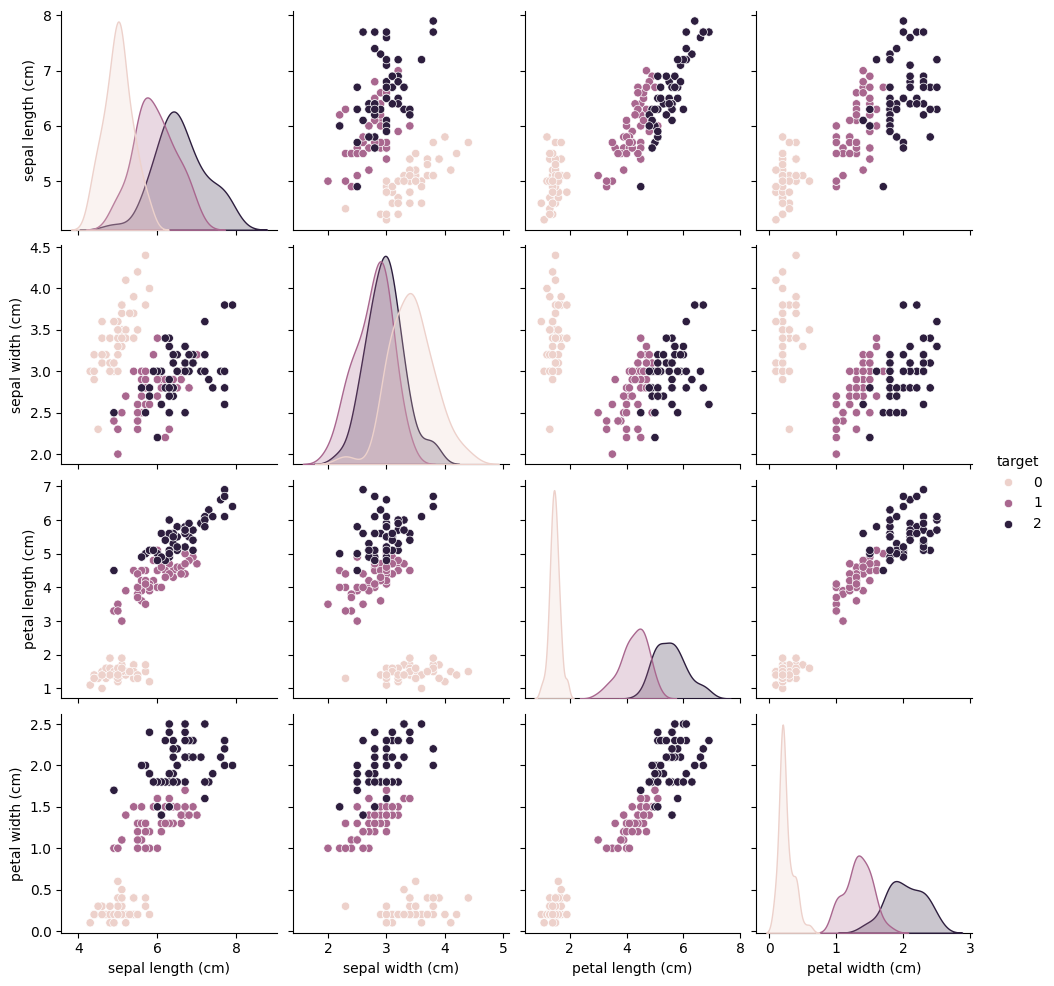

In [7]:
iris_df = pd.DataFrame(X, columns=iris_ds["feature_names"])
iris_df["target"] = y
sns.pairplot(iris_df, hue = "target")

# Gaussian / Normal Distributions

Probability Density Function (PDF):

$$
    f(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left[ \frac{-(x - \mu)^2}{2\sigma^2}\right]
$$


In [8]:
def gaussian_pdf(x, loc=0, scale=1):
    # TODO
    pass

In [9]:
def gaussian_pdf(x, loc=0, scale=1):
    norm = 1 / (scale * np.sqrt(2 * np.pi))
    p = -1 * np.power(x - loc, 2)
    q = 2 * np.power(scale, 2)
    return norm * np.exp(p / q)

In [10]:
class GaussianNaiveBayes:
    def __init__(self):
        self.loc_ = None
        self.scale_ = None
        self.priors_ = None
        self.classes_ = None
        self.feature_names_ = None

    def fit(self, X, y):
        self.classes_, self.priors_ = np.unique(y, return_counts=True)
        self.priors_ = self.priors_.astype(float) / len(y)
        _, p = X.shape
        self.loc_ = np.zeros(shape=(len(self.classes_), p))
        self.scale_ = np.zeros(shape=(len(self.classes_), p))
        for i, c in enumerate(self.classes_):
            self.loc_[i] = np.mean(X[y == c], axis=0)
            self.scale_[i] = np.std(X[y == c], axis=0)
        return self

    def predict(self, X):
        n, p = X.shape
        norm_probas = np.zeros(shape=(n, p, len(self.classes_)))
        for i, c in enumerate(self.classes_):
            norm_probas[:, :, i] = gaussian_pdf(X, self.loc_[i], self.scale_[i])
        # NAIVE Assumption: features are independent
        # compute likelihood by multiplying along feature axis
        likelihood = np.prod(norm_probas, axis=1)
        posterior = likelihood * self.priors_
        prediction = np.argmax(posterior, axis=1)
        return prediction

In [85]:
from matplotlib.patches import Ellipse

def plot_gnb(gnb):
    # makeshift solution to get matching ellipse patch colors...
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    c, p = gnb.loc_.shape
    fig, axs = plt.subplots(p, p, figsize=(10,10), sharex="col", sharey="row")
    for i in range(p):
        for j in range(p):
            if gnb.feature_names_:
                if i == p - 1:
                    axs[i,j].set_xlabel(gnb.feature_names_[j])
                if j == 0:
                    axs[i,j].set_ylabel(gnb.feature_names_[i])
            if i == j:
                loc = gnb.loc_[:, i]
                scale = gnb.scale_[:, i]
                x = np.linspace(loc - 2 * scale, loc + 2 * scale, 100)
                y = gaussian_pdf(x, loc, scale)
                axii = axs[i,i].twinx()
                axii.set_yticks([])
                for k, c in enumerate(gnb.classes_):
                    axii.plot(x[:,k], y[:,k], label=c)
            else:
                for k, c in enumerate(gnb.classes_):
                    loc_x = gnb.loc_[k, j]
                    loc_y = gnb.loc_[k, i]
                    axs[i,j].scatter(loc_x, loc_y, label=c) 
                    std_patch = Ellipse((loc_x, loc_y), width=gnb.scale_[k,i], height=gnb.scale_[k,j], facecolor='none', edgecolor=cycle[k], alpha=0.5)
                    axs[i,j].add_patch(std_patch)

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19)

model = GaussianNaiveBayes()
model.fit(X_train, y_train)
model.feature_names_ = feature_names

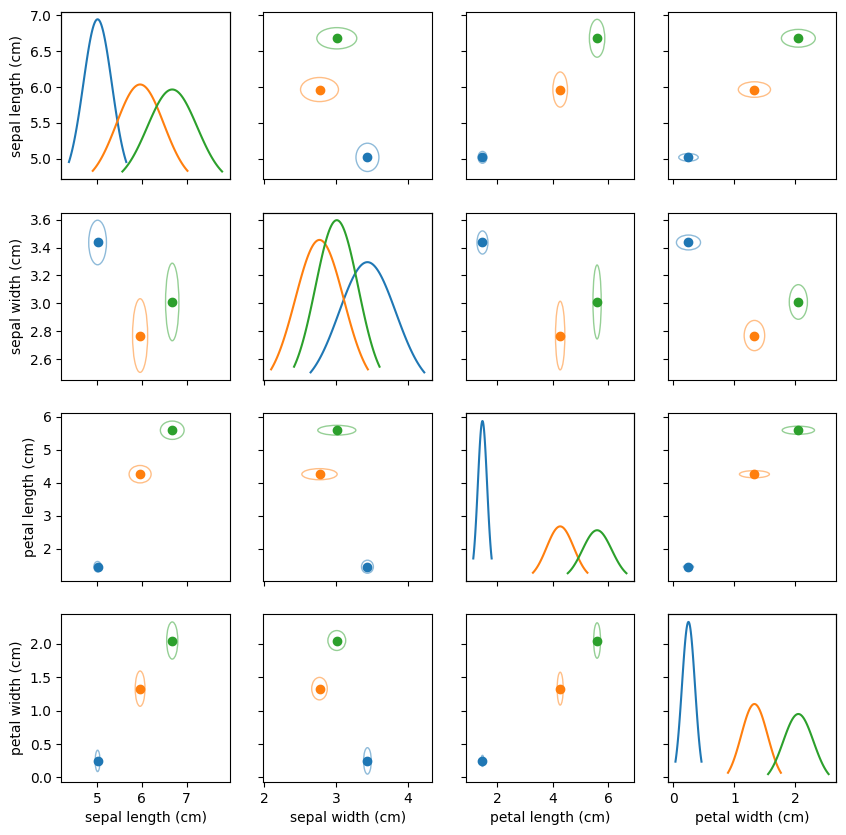

In [87]:
plot_gnb(model)

In [88]:
from sklearn.metrics import accuracy_score

y_hat = model.predict(X_test)

accuracy_score(y_hat, y_test)

0.9210526315789473

## References

- https://en.wikipedia.org/wiki/Naive_Bayes_classifier
- https://scikit-learn.org/stable/modules/naive_bayes.html